In [13]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from scripts.functions import get_dataset
from scripts.functions import add_zipcode
from scripts.functions import add_province
from scripts.functions import add_region
from scripts.functions import set_type
from scripts.functions import set_feat_target
from scripts.functions import regline

import sys
# Ensure that import from parent directory is correctly implemented
sys.path.append('..')
from scripts.colors import bcolors as bc

## Modeling 
- Load datas
- Add zipcode from csv, based on locality column
- Add Provinces based on zipcode

In [14]:
# Load the datas 
file = '../datas/Immoweb_data_ok_maite.csv'
data = get_dataset(file)
data.head()
# data.dtypes

,Id,Locality,House or appartment?,Subtype,Price,Type of sale,Number of rooms,Living area,Fully equipped kitchen,Furnished,Open fire,Terrace,Area of terrace,Garden,Area of garden,Land surface,Number of facades,Swimming pool,State of building
0,10233388,Uccle,HOUSE,HOUSE,1295000.0,BUY_REGULAR,4.0,290.0,1,None,0,1,15,None,None,230,2,0,GOOD
2,10310451,Anderlecht,APARTMENT,APARTMENT,357500.0,BUY_REGULAR,3.0,119.0,0,None,0,1,16,None,None,None,4,None,NaN
3,10309870,Uccle,APARTMENT,APARTMENT,295000.0,BUY_REGULAR,2.0,140.0,0,None,0,None,None,None,None,None,2,None,TO_BE_DONE_UP
4,10309546,Uccle,APARTMENT,APARTMENT,199000.0,BUY_REGULAR,1.0,61.0,0,None,0,1,2,None,None,None,2,None,NaN
5,10308639,Berchem-Sainte-Agathe,HOUSE,HOUSE,485000.0,BUY_REGULAR,3.0,235.0,0,None,0,None,None,1,100,200,2,0,TO_BE_DONE_UP


In [15]:

# Add zipcode column
zip_path = "../datas/Postal_codes.csv"
data = add_zipcode(zip_path, data)
# Add Province column
data = add_province(data)
# Add Region column
data = add_region(data)
data = set_type(data)
# Explore data
data.head()
# data.isnull().sum()
data['Subtype'].unique()
# data.dtypes



array(['HOUSE', 'APARTMENT', 'PENTHOUSE', 'FLAT_STUDIO', 'GROUND_FLOOR',
       'VILLA', 'APARTMENT_BLOCK', 'DUPLEX', 'MANSION',
       'MIXED_USE_BUILDING', 'EXCEPTIONAL_PROPERTY', 'TRIPLEX',
       'TOWN_HOUSE', 'OTHER_PROPERTY', 'PAVILION', 'LOFT', 'SERVICE_FLAT',
       'KOT', 'BUNGALOW', 'FARMHOUSE', 'COUNTRY_COTTAGE', 'CHALET',
       'MANOR_HOUSE', 'CASTLE'], dtype=object)

In [16]:
# print(data.info())
# print(data.describe())
# print(data['Region'].value_counts())
# print(data['Number of rooms'].value_counts())
# data['Number of facades'].unique()

#### Correlation

C:\Users\meule\AppData\Local\Temp\ipykernel_15736\540660637.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = data.corr()


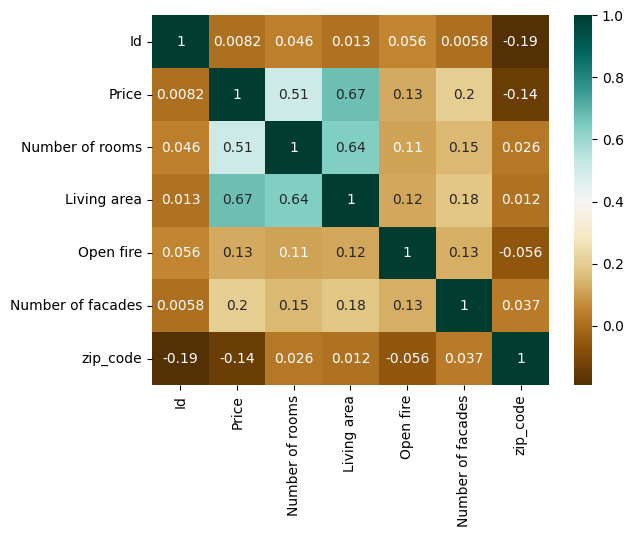

In [17]:
correlation = data.corr()
dataplot = sns.heatmap(correlation, cmap="BrBG", annot=True)

### Sort correlation to Price

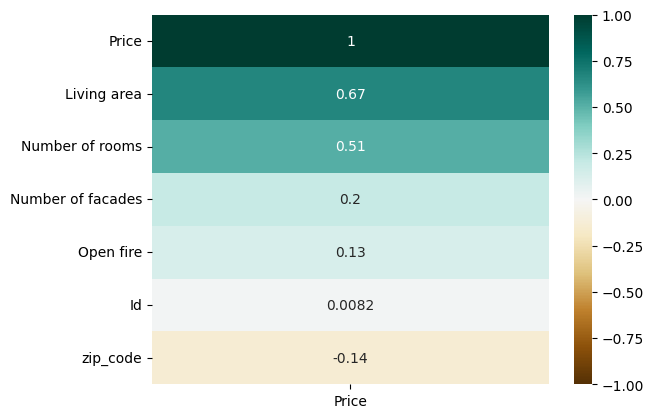

In [18]:
heatmap = sns.heatmap(correlation[['Price']].sort_values(by='Price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')

### Explore data outliers

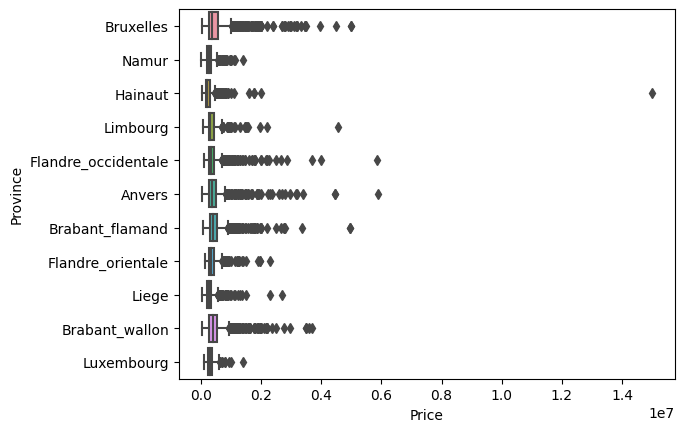

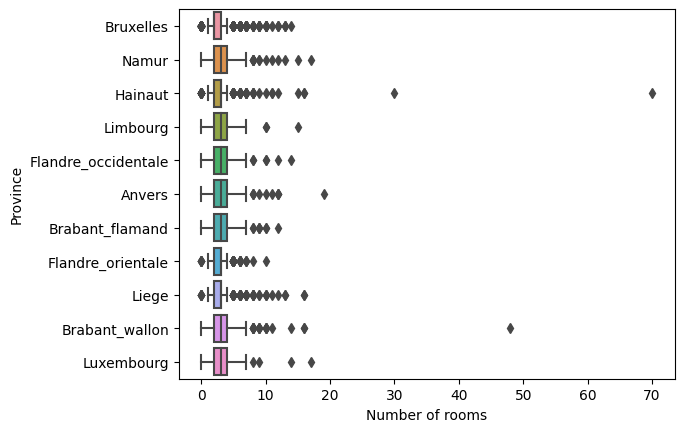

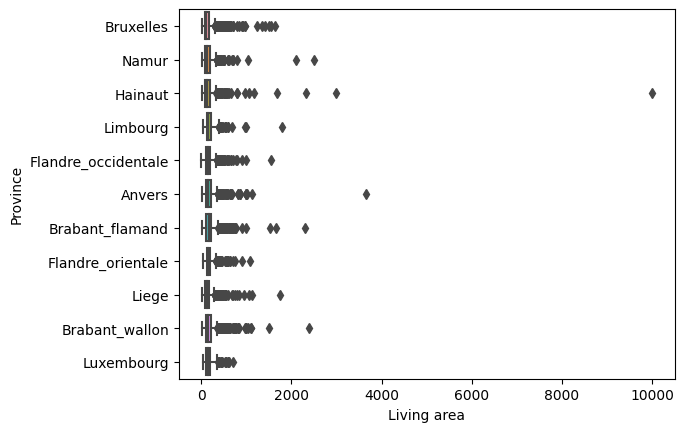

In [19]:
plt.figure()
outliers_Price = sns.boxplot(data=data, x="Price", y='Province')
plt.figure()
outliers_Number_of_rooms = sns.boxplot(data=data, x="Number of rooms", y='Province')
plt.figure()
outliers_Living_area = sns.boxplot(data=data, x="Living area", y='Province')
# sns.close()


In [20]:
# print(data['Price'].describe())
# Remove outliers from Price column
q1_price , q3_price = data['Price'].quantile([0.25,0.75])
iqr_price = q3_price - q1_price
print(q1_price, q3_price, iqr_price)
iqr_coef = 1.5
data = data[(data['Price'] > (q1_price - (iqr_coef*iqr_price))) & (data['Price'] < (q3_price + (iqr_coef*iqr_price)))]
# print(data['Price'].describe())

# Remove outliers from Living area column
print(data['Living area'].describe())
q1_la , q3_la = data['Living area'].quantile([0.25,0.75])
iqr_price = q3_la - q1_la
print(q1_la, q3_la, iqr_price)
iqr_coef = 2
data = data[(data['Living area'] > (q1_la - (iqr_coef*iqr_price))) & (data['Living area'] < (q3_la + (iqr_coef*iqr_price)))]
print(data['Living area'].describe())

# Remove outliers from Number of rooms column
print(data['Number of rooms'].describe())
q1_nr , q3_nr = data['Number of rooms'].quantile([0.25,0.75])
iqr_price = q3_nr - q1_nr
print(q1_nr, q3_nr, iqr_price)
iqr_coef = 5
data = data[(data['Number of rooms'] > (q1_nr - (iqr_coef*iqr_price))) & (data['Number of rooms'] < (q3_nr + (iqr_coef*iqr_price)))]
print(data['Number of rooms'].describe())

plt.show()

249000.0 471997.0 222997.0
count    9208.000000
mean      153.805712
std        99.581505
min         1.000000
25%        96.000000
50%       135.000000
75%       185.000000
max      3665.000000
Name: Living area, dtype: float64
96.0 185.0 89.0
count    8950.000000
mean      143.672626
std        63.801115
min         1.000000
25%        95.000000
50%       132.000000
75%       180.000000
max       360.000000
Name: Living area, dtype: float64
count    8950.000000
mean        2.748156
std         1.198219
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max        11.000000
Name: Number of rooms, dtype: float64
2.0 3.0 1.0
count    8926.000000
mean        2.731795
std         1.156636
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         7.000000
Name: Number of rooms, dtype: float64


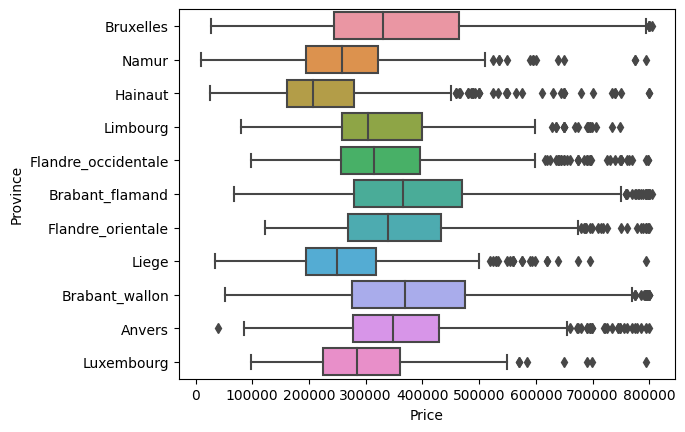

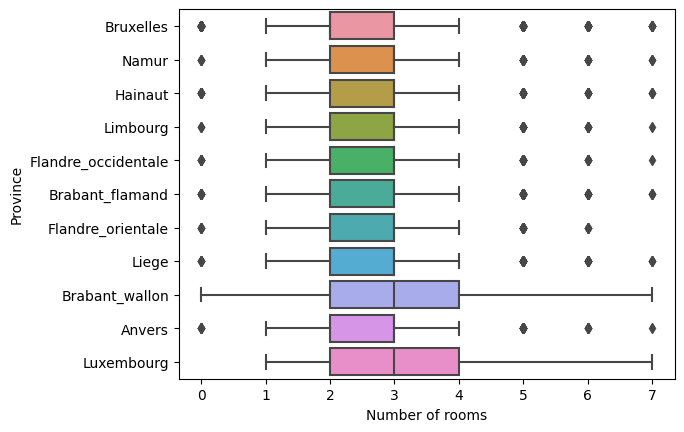

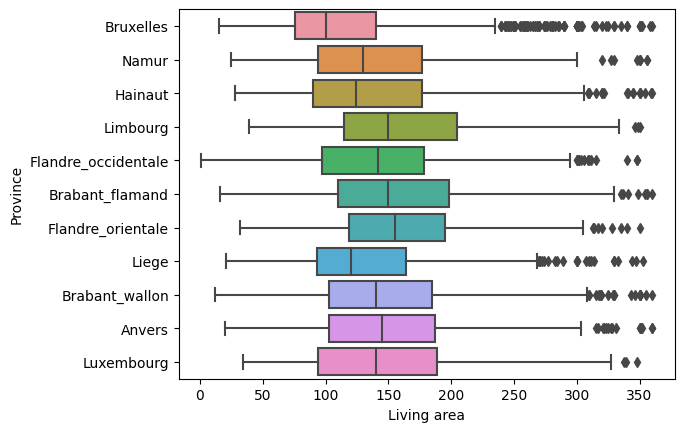

In [21]:
plt.figure()
outliers_removed_Price = sns.boxplot(data=data, x="Price", y='Province')
plt.figure()
outliers_removed_Number_of_rooms = sns.boxplot(data=data, x="Number of rooms", y='Province')
plt.figure()
outliers_removed_Living_area = sns.boxplot(data=data, x="Living area", y='Province')
# sns.close()

- Slice df for modeling
- Split feature, target
- Split train, test
- Normalize or standardise

In [22]:
# Select columns for modeling
# print(data.columns)
data_model_house = data[data['House or appartment?'] == 'HOUSE'][['Price', 'Province', 'Living area','Number of rooms', 'Number of facades', 'Subtype', 'State of building']]
print(data_model_house.head())
print(data_model_house.shape[0])
# Get dummies for Province columns
data_model_house = pd.get_dummies(data_model_house, columns =['Province'],drop_first=False )
data_model_house = pd.get_dummies(data_model_house, columns =['Subtype'],drop_first=False )
data_model_house = pd.get_dummies(data_model_house, columns =['State of building'],drop_first=False )
print(data_model_house.columns)
# Split features, target
X, y = set_feat_target(data_model_house)
# Split into train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.20, random_state= 12)
# Standardisation
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
# print(f"y head : {y[:1,:]},\nX head : {X[:1,:]}")
# print(f"y_test first : {y_test[:1,:]},\nX_test first : {X_test[:1,:]}")

KeyError: "['State of buiding'] not in index"

### Linear Regression
- Instanciate linear regression
- Fit the model and get score
- Test the model and get score


In [ ]:
# Model instanciation
regressor = linear_model.LinearRegression()

# Train the model
regressor.fit(X_train, y_train)
print(f"REGRESSOR\n {bc.OKBLUE}Intercept{bc.ENDC}: {regressor.intercept_[0]},\n {bc.OKBLUE}Coef{bc.ENDC}:{regressor.coef_[0]}")
accuracy_train = round(regressor.score(X_train, y_train)*100,2)
print(f"Linear {bc.OKBLUE}train{bc.ENDC} score : {bc.OKGREEN if accuracy_train > 60 else bc.WARNING if accuracy_train > 50 else bc.FAIL}{accuracy_train}{bc.ENDC} %")

# Test the model
accuracy_test = round(regressor.score(X_test, y_test)*100, 2)
print(f"Linear {bc.OKBLUE}test{bc.ENDC} score : {bc.OKGREEN if accuracy_test > 60 else bc.WARNING if accuracy_test > 50 else bc.FAIL}{accuracy_test}{bc.ENDC} %")

# Prediction
pred_test = regressor.predict(X_test)
pred_train = regressor.predict(X_train)

REGRESSOR
 Intercept: 357566.2615577113,
 Coef:[ 5.97898938e+04  1.23927806e+04  2.60077167e+04 -1.38190265e+18
 -1.84672981e+18 -1.65082792e+18 -1.16277725e+18 -1.37753549e+18
 -1.43273166e+18 -1.36430654e+18 -1.24076803e+18 -1.03095831e+18
 -7.15907234e+17 -1.21494008e+18]
Linear train score : 49.32 %
Linear test score : 47.18 %


### Plot results

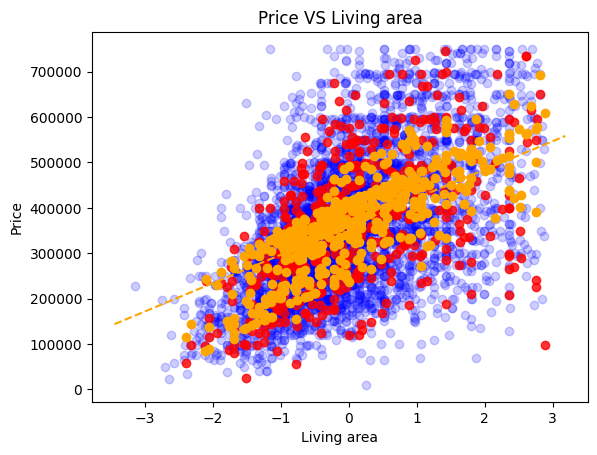

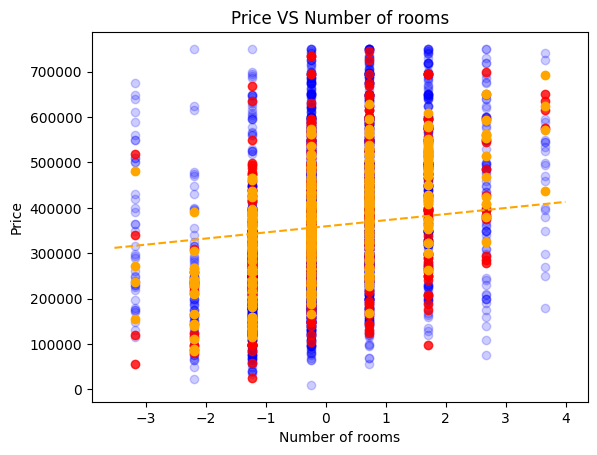

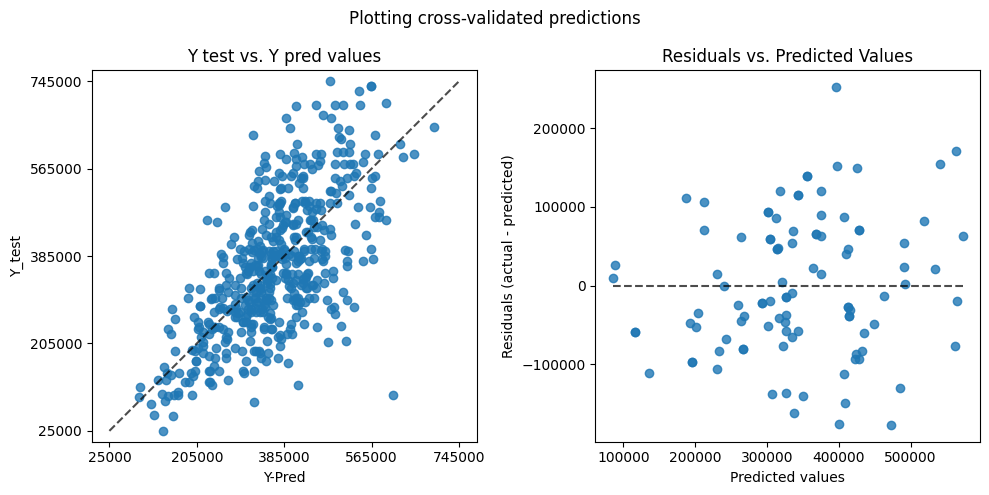

In [ ]:
# X[0] = "Living Area"
# X[1] = "Number of rooms"
# X[2:] = "Province"

# Price vs Living area
# Plot the predicted values against the input values
plt.scatter(X_train[:,0], y_train, color='blue',alpha=0.2)
# plt.scatter(X_train[:,0], pred_train, color='red')
plt.scatter(X_test[:,0], y_test, color='red', alpha=0.8)
plt.scatter(X_test[:,0], pred_test, color='orange')
line_Living_area = regline(regressor.coef_[0][0],regressor.intercept_[0],'orange')

# Label the plot
plt.title("Price VS Living area")
plt.xlabel('Living area')
plt.ylabel('Price')

# Show the plot
plt.show()
plt.close()

# Price vs Number of rooms
# Plot the predicted values against the input values
plt.scatter(X_train[:,1], y_train, color='blue', alpha=0.2)
# plt.scatter(X_train[:,1], pred_train, color='red')
plt.scatter(X_test[:,1], y_test, color='red', alpha=0.8)
plt.scatter(X_test[:,1], pred_test, color='orange')
# print(regressor.intercept_[0],regressor.coef_[0][1])
line_Number_rooms = regline(regressor.coef_[0][1],regressor.intercept_[0],'orange')

# Label the plot
plt.title("Price VS Number of rooms")
plt.xlabel('Number of rooms')
plt.ylabel('Price')

# Show the plot
plt.show()
plt.close()

fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=pred_test,
    kind="actual_vs_predicted",
    # subsample=100,
    ax=axs[0],
    # random_state=0,
)
axs[0].set_title("Y test vs. Y pred values")
axs[0].set_xlabel("Y-Pred")
axs[0].set_ylabel("Y_test")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=pred_test,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
plt.show()
plt.close()
